# Using only 8 orthophotos with 50cm pixel resolution

- manually copy 50cm images to new folders './../laco.ai_50/images' and './../laco.ai_50/masks'
- rerun prepareInputData.py with two parameter changes
    - main_folder = './../laco.ai_50'
    - DATA_FOLDER = './../Data_50'

In [17]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from PIL import Image

IMAGE_SIZE = 512
BATCH_SIZE = 1
NUM_CLASSES = 5
NUM_TRAIN_IMAGES = 1000

#train_sat_folder = "./../Data_50/train/sat/"
#train_gt_folder = "./../Data_50/train/gt/"

train_sat_folder = "./../Data_50/validate/sat/"
train_gt_folder = "./../Data_50/validate/gt/"

val_sat_folder = "./../Data_50/validate/sat/"
val_gt_folder = "./../Data_50/validate/gt/"

# Function to load and preprocess the dataset
def load_data(sat_folder, gt_folder, num_classes, batch_size=1):
    input_images = []
    output_masks = []

    filenames = [filename for filename in os.listdir(sat_folder) if filename.endswith(".tif")]
    num_batches = len(filenames) // batch_size

    for batch_idx in tqdm(range(num_batches), desc="Loading batches", unit="batch"):
        batch_filenames = filenames[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        
        batch_inputs = []
        batch_outputs = []
        for filename in batch_filenames:
            input_path = os.path.join(sat_folder, filename)
            output_path = os.path.join(gt_folder, filename.replace("sat_", "gt_"))

            # Load and preprocess input image
            input_image = np.array(Image.open(input_path)) / 255.0  # Normalize to [0, 1]
            batch_inputs.append(input_image)

            # Load and preprocess output mask
            output_mask = np.array(Image.open(output_path))

            # Ensure that class indices are within the range [0, num_classes-1]
            output_mask = np.clip(output_mask, 0, num_classes - 1)
            output_mask = keras.utils.to_categorical(output_mask, num_classes=num_classes)
            batch_outputs.append(output_mask)

        input_images.append(np.array(batch_inputs))
        output_masks.append(np.array(batch_outputs))

    return np.vstack(input_images), np.vstack(output_masks)

# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder, NUM_CLASSES, BATCH_SIZE)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder, NUM_CLASSES, BATCH_SIZE)

Loading batches: 100%|██████████| 72/72 [00:00<00:00, 85.73batch/s]


In [18]:
# deeplabv3_plus architecture found on https://keras.io/examples/vision/deeplabv3_plus/

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        activation="relu"
    )(block_input)
    x = layers.BatchNormalization()(x)
    #return ops.nn.relu(x)
    return x


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
        #interpolation="lanczos",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [25]:
# deeplabv3_plus architecture found on https://keras.io/examples/vision/deeplabv3_plus/

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [26]:
model_deeplabv3 = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model_deeplabv3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_3  (None, 512, 512, 3)          0         ['input_4[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_3 (TFOpLamb  (None, 512, 512, 3)          0         ['tf.__operators__.getitem_3[0
 da)                                                                ][0]']                        
                                                                                            

In [27]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [28]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
import matplotlib.pyplot as plt

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [41]:
# warning: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of ... exceeds 10% of free system memory.
# adding steps_per_epoch=STEPS_PER_EPOCH to model.fit method
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import tensorflow as tf


import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

STEPS_PER_EPOCH = 100

#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = "categorical_crossentropy"
#loss = keras.metrics.BinaryAccuracy()
#loss = keras.losses.sparse_categorical_crossentropy(
#    y_true = y_train,
#    from_logits = False,
#    ignore_class = '0',
#    axis = -1
#)

model_deeplabv3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    #metrics=["accuracy"],
    metrics=METRICS,
)

#history = model_deeplabv3.fit(train_dataset, validation_data=val_dataset, epochs=25)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'deeplabv3_model_{epoch:02d}_{val_accuracy:.3f}.keras',
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,  # Save entire model
    mode='max',  # Save the model with the highest validation accuracy
    verbose=1
)

model_history = model_deeplabv3.fit(X_train, y_train,
                          epochs=10,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val, y_val),
                          #class_weight=class_weight_dict,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[checkpoint]
)

plt.plot(model_history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


Epoch 1/10


# Filtered_80


In [1]:
# Add the path to the Utils folder
import sys
sys.path.append('../Utils')

from notebookUtils import visualize_class_distribution

import os
import shutil

def copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder):
    os.makedirs(os.path.join(destination_folder, "sat"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "gt"), exist_ok=True)

    for source_file in filtered_sat_files:
        destination_path = os.path.join(destination_folder, "sat", os.path.basename(source_file))
        shutil.copyfile(source_file, destination_path)

    for source_file in filtered_gt_files:
        destination_path = os.path.join(destination_folder, "gt", os.path.basename(source_file))
        shutil.copyfile(source_file, destination_path)

In [3]:
import os
import numpy as np
from PIL import Image

def filter_data_by_class(folder, class_name, threshold_percent):
    sat_folder = os.path.join(folder, "sat")
    gt_folder = os.path.join(folder, "gt")

    filtered_sat_files = []
    filtered_gt_files = []

    for filename in os.listdir(gt_folder):
        if filename.endswith(".tif") and filename.startswith("gt_"):
            gt_path = os.path.join(gt_folder, filename)
            sat_path = os.path.join(sat_folder, filename.replace("gt_", "sat_"))

            # Load ground truth mask
            gt_mask = np.array(Image.open(gt_path))

            # Calculate the percentage of the specified class
            class_percent = np.sum(gt_mask == class_name) / gt_mask.size * 100.0

            # Check if the class percentage is below the threshold
            if class_percent <= threshold_percent:
                filtered_gt_files.append(gt_path)
                filtered_sat_files.append(sat_path)

    return filtered_sat_files, filtered_gt_files

Processing files:   0%|          | 0/5999 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 5999/5999 [04:43<00:00, 21.17file/s]


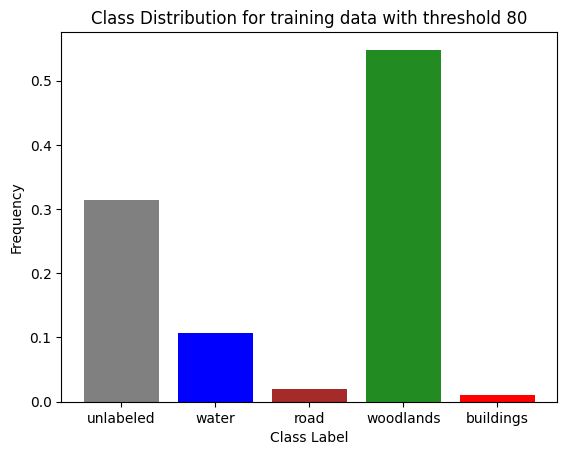

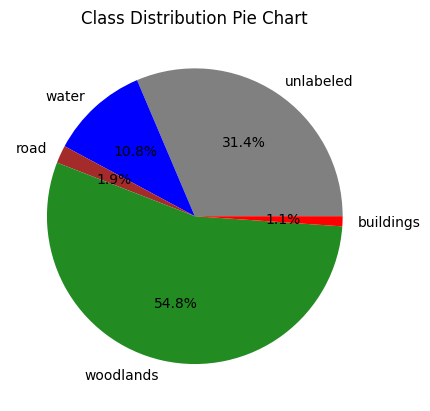

Class Distribution Summary:
unlabeled: 493629916 samples, 31.39%
water: 169219862 samples, 10.76%
road: 30631834 samples, 1.95%
woodlands: 861846209 samples, 54.80%
buildings: 17274035 samples, 1.10%


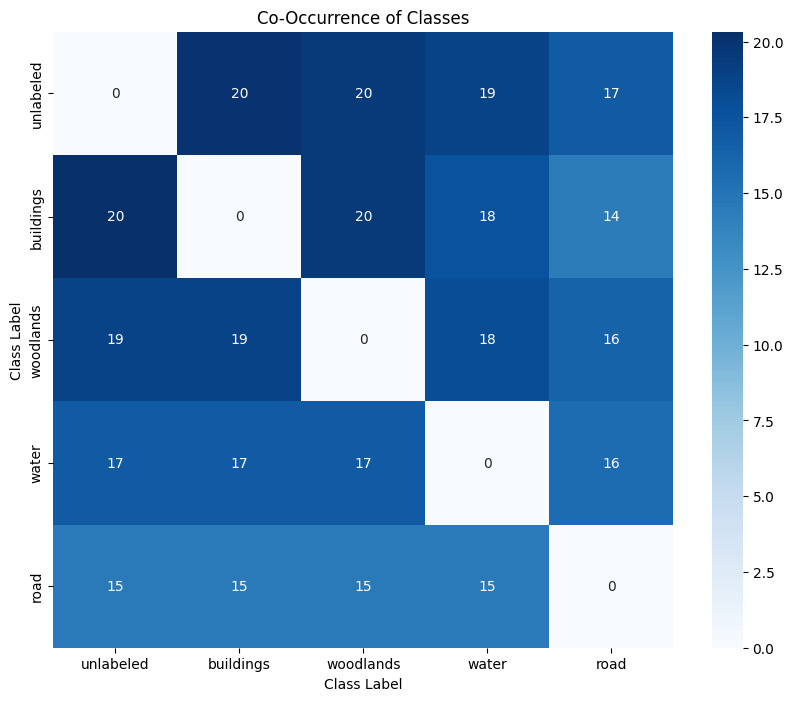

In [4]:
data_folder = "./../Data_50/train/"
class_name = 0
threshold_percent = 80  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_50_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")